In [1]:
import pandas as pd
import loguru
from loguru import logger
from data.dataset import Sentinel2Dataset
from data.loader import define_loaders
from utils.utils import load_config
import torch
import torch.nn as nn
from tqdm import tqdm
import os
import cv2
import matplotlib.pyplot as plt

from model_zoo.models import define_model
import torch.optim as optim
from utils.torch import count_parameters, seed_everything, load_model_weights
from training.losses import masked_mse_loss
import numpy as np

/home/ubuntu/miniconda3/envs/ai_processor/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [49]:
config = load_config(config_path="cfg/config.yaml")
BASE_DIR = config["DATASET"]["base_dir"]
VERSION = config['DATASET']['version']
BANDS = config['DATASET']['bands']
SEED = config['TRAINING']['seed']
RESIZE = config['TRAINING']['resize']
NUM_WORKERS = config['TRAINING']['num_workers']
BATCH_SIZE = 1
test_path = f"{BASE_DIR}/{VERSION}/test_path.csv"
df_test = pd.read_csv(test_path)
df_test = df_test[188:189]


test_dataset = Sentinel2Dataset(df_path=df_test,
                                 train=True, augmentation=False,
                                 img_size=RESIZE)

test_loader =  define_loaders(
        train_dataset=test_dataset,
        val_dataset=None,
        train=False,
        batch_size=1,
        num_workers=NUM_WORKERS,
    )

In [50]:
weights_path = "/home/ubuntu/project/sentinel-2-ai-processor/results/checkpoints/best_model.pth"

model = define_model(name=config["MODEL"]["model_name"],
                     encoder_name=config["MODEL"]["encoder_name"],
                     in_channel=len(BANDS),
                     out_channels=len(BANDS),
                     activation=None)
# Model Test - load best model weights
model = load_model_weights(model=model, filename=weights_path)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

2025-04-22 17:04:23.244 | INFO     | utils.torch:load_model_weights:95 - 
 -> Loading encoder weights from /home/ubuntu/project/sentinel-2-ai-processor/results/checkpoints/best_model.pth



In [58]:
from training.metrics import MultiSpectralMetrics
criterion = nn.MSELoss()
model.eval()
test_loss = 0.0
test_metrics_tracker = MultiSpectralMetrics(bands=BANDS, device=device)
test_metrics = {
    "test_loss": 0.0,
    "test_psnr": {band: 0.0 for band in BANDS},
    "test_rmse": {band: 0.0 for band in BANDS},
    "test_ssim": {band: 0.0 for band in BANDS},
    "test_sam": {band: 0.0 for band in BANDS},
}
with torch.no_grad():
    with tqdm(total=(len(test_dataset) - len(test_dataset) % BATCH_SIZE), ncols=100, colour='#cc99ff') as t:
        t.set_description('testing')

        for batch_idx, (x_data, y_data) in enumerate(test_loader):
            x_data = x_data.to(device)
            y_data = y_data.to(device)
            valid_mask = (y_data >= 0)

            # Forward pass
            outputs = model(x_data)

            # Update test metrics
            test_metrics_tracker.update(outputs, y_data)

            # Calculate loss
            loss = criterion(outputs[valid_mask], y_data[valid_mask])

            # Update statistics
            batch_loss = loss.item()
            test_loss += batch_loss

            # Update progress bar
            t.set_postfix(loss=batch_loss)
            t.update(x_data.size(0))

# Calculate average test loss
# Calculate average test loss
avg_test_loss = test_loss / len(test_loader)
test_metrics['test_loss'] = avg_test_loss

# Get test metrics
test_epoch_metrics = test_metrics_tracker.compute()

# Store test metrics
for band in BANDS:
    test_metrics['test_psnr'][band] = test_epoch_metrics[band]['psnr']
    test_metrics['test_rmse'][band] = test_epoch_metrics[band]['rmse']
    test_metrics['test_ssim'][band] = test_epoch_metrics[band]['ssim']
    test_metrics['test_sam'][band] = test_epoch_metrics[band]['sam']

    # Print metrics for each band
    print(f"Band {band}: Test PSNR: {test_epoch_metrics[band]['psnr']:.4f}, "
          f"RMSE: {test_epoch_metrics[band]['rmse']:.4f}, "
          f"SSIM: {test_epoch_metrics[band]['ssim']:.4f}, "
          f"SAM: {test_epoch_metrics[band]['sam']:.5f}°")

# Log test metrics
test_metrics_str = ", ".join([f"Test PSNR {band}: {test_metrics['test_psnr'][band]:.4f}" for band in BANDS])
logger.info(f"Test Loss: {avg_test_loss:.6f}, {test_metrics_str}")

testing:   0%|                                                                | 0/1 [00:00<?, ?it/s]

testing: 100%|█████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s, loss=0.000874]
2025-04-22 17:04:52.309 | INFO     | __main__:<module>:62 - Test Loss: 0.000874, Test PSNR B02: 30.8164, Test PSNR B03: 30.7229, Test PSNR B04: 30.2420


Band B02: Test PSNR: 30.8164, RMSE: 0.0288, SSIM: 0.9694, SAM: 0.02930°
Band B03: Test PSNR: 30.7229, RMSE: 0.0291, SSIM: 0.9666, SAM: 0.02918°
Band B04: Test PSNR: 30.2420, RMSE: 0.0308, SSIM: 0.9655, SAM: 0.03134°


In [52]:
df_test

,Unnamed: 0,l1c_path,l2a_path,GeoFootprint
188,4772,/mnt/disk/dataset/sentinel-ai-processor/V1/inp...,/mnt/disk/dataset/sentinel-ai-processor/V1/out...,"{'type': 'Polygon', 'coordinates': [[[5.671539..."


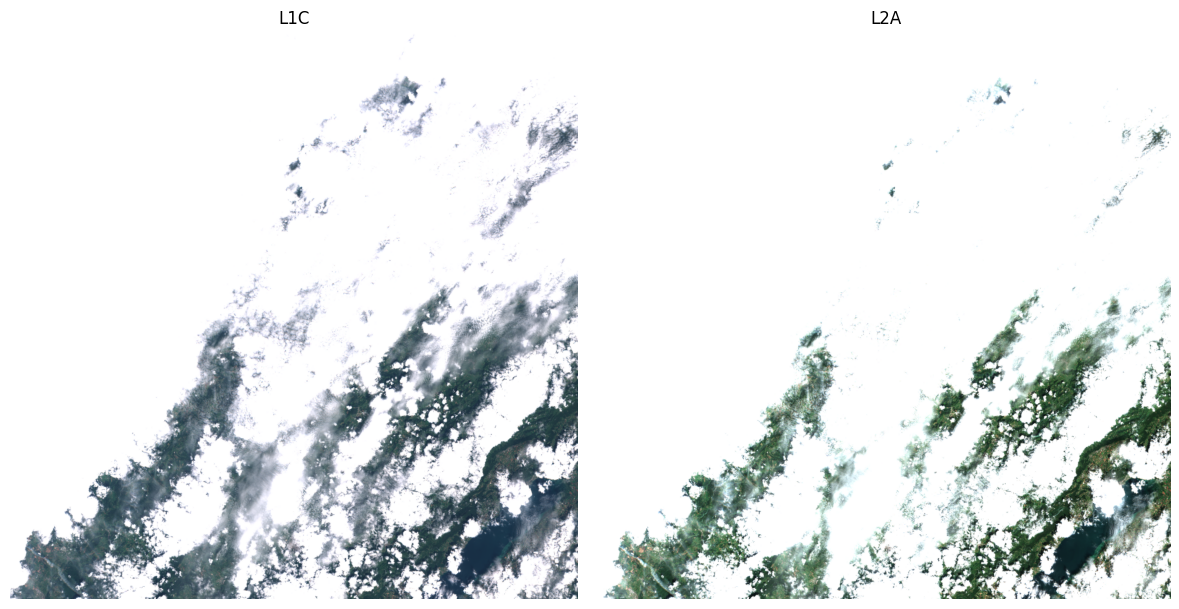

In [53]:
x_path = df_test.l1c_path.iloc[0]
x_data = cv2.imread(x_path)
y_path = df_test.l2a_path.iloc[0]
y_data = cv2.imread(y_path)

x_data = cv2.cvtColor(x_data, cv2.COLOR_BGR2RGB)
x_data = cv2.resize(x_data, (1024, 1024), interpolation=cv2.INTER_AREA)
y_data = cv2.cvtColor(y_data, cv2.COLOR_BGR2RGB)
y_data = cv2.resize(y_data, (1024, 1024), interpolation=cv2.INTER_AREA)

# Display the RGB composites
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(x_data)
axes[0].set_title("L1C")
axes[0].axis('off')

axes[1].imshow(y_data)
axes[1].set_title("L2A")
axes[1].axis('off')

plt.tight_layout()
plt.show()

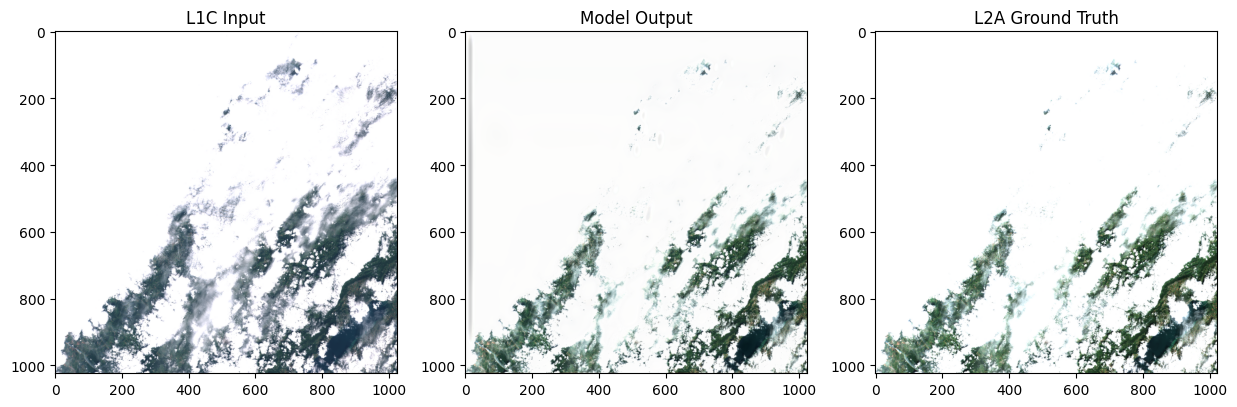

In [54]:
x_data = np.array(x_data).astype(np.float32) / 255.0
x_data = torch.from_numpy(x_data).float()
x_data = torch.permute(x_data, (2, 0, 1))  # HWC to CHW
y_data = np.array(y_data).astype(np.float32) / 255.0
y_data = torch.from_numpy(y_data).float()
y_data = torch.permute(y_data, (2, 0, 1))  # HWC to CHW

y_data = torch.unsqueeze(y_data, 0)
x_data = torch.unsqueeze(x_data, 0)

with torch.no_grad():


    x_data = x_data.to(device)
    y_data = y_data.to(device)
    valid_mask = (y_data >= 0)

    # Forward pass
    outputs = model(x_data)
# Convert to numpy for visualization
x_np = x_data.cpu().numpy()[0].transpose(1, 2, 0)  # First image in batch, CHW to HWC
y_np = y_data.cpu().numpy()[0].transpose(1, 2, 0)
pred_np = outputs.cpu().numpy()[0].transpose(1, 2, 0)

# Clip values to valid range for visualization
x_np = np.clip(x_np, 0, 1)
y_np = np.clip(y_np, 0, 1)
pred_np = np.clip(pred_np, 0, 1)

# Plot and save
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(x_np)
axs[0].set_title('L1C Input')
axs[1].imshow(pred_np)
axs[1].set_title('Model Output')
axs[2].imshow(y_np)
axs[2].set_title('L2A Ground Truth')
plt.show()

In [55]:
def compute_sam(prediction: torch.Tensor, target: torch.Tensor, valid_mask=None) -> torch.Tensor:
    """
    Compute Spectral Angle Mapper (SAM) between two single-channel images.

    Args:
        prediction: Prediction tensor of shape [H, W]
        target: Target tensor of shape [H, W]
        valid_mask: Optional boolean mask of valid pixels, shape [H, W]. If None, all pixels are considered valid.

    Returns:
        Spectral angle in radians (torch.Tensor scalar)
    """
    # Apply mask if provided
    if valid_mask is None:
        valid_mask = torch.ones_like(target, dtype=torch.bool)
    else:
        # Ensure we're working with a boolean mask
        valid_mask = valid_mask.bool()

    # Extract valid pixels only
    pred_valid = prediction[valid_mask]
    target_valid = target[valid_mask]

    # If no valid pixels, return 0
    if pred_valid.numel() == 0:
        return torch.tensor(0.0, device=prediction.device)

    # Compute dot product and norms
    dot_product = torch.sum(pred_valid * target_valid)
    pred_norm = torch.sqrt(torch.sum(pred_valid**2))
    target_norm = torch.sqrt(torch.sum(target_valid**2))

    # Compute cosine similarity, handling potential division by zero
    cos_sim = dot_product / (pred_norm * target_norm + 1e-8)

    # Clamp to handle numerical errors
    # cos_sim = torch.clamp(cos_sim, -1.0, 1.0)

    # Compute spectral angle in radians
    angle = torch.acos(cos_sim)

    return angle

In [60]:
# Extract single channel from first sample (H x W tensors)
outputs_c = outputs[0, 0, :, :]
targets_c = y_data[0, 0, :, :]

# Create mask for valid pixels
valid_mask = (targets_c >= 0)

# Compute SAM
angle = compute_sam(outputs_c, targets_c, valid_mask)
print(angle.item())

0.029301991686224937
